In [53]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import random

In [28]:
import zipfile
import os

zip_path = "data.zip" # Unzip

extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Set paths
with_mask_dir = os.path.join(extract_path, "with_mask")
without_mask_dir = os.path.join(extract_path, "without_mask")

# Check number of files in each class

print("Total images with mask:", len(os.listdir(with_mask_dir)))
print("Total images without mask:", len(os.listdir(without_mask_dir)))


Total images with mask: 3725
Total images without mask: 3828


# Show Sample Images

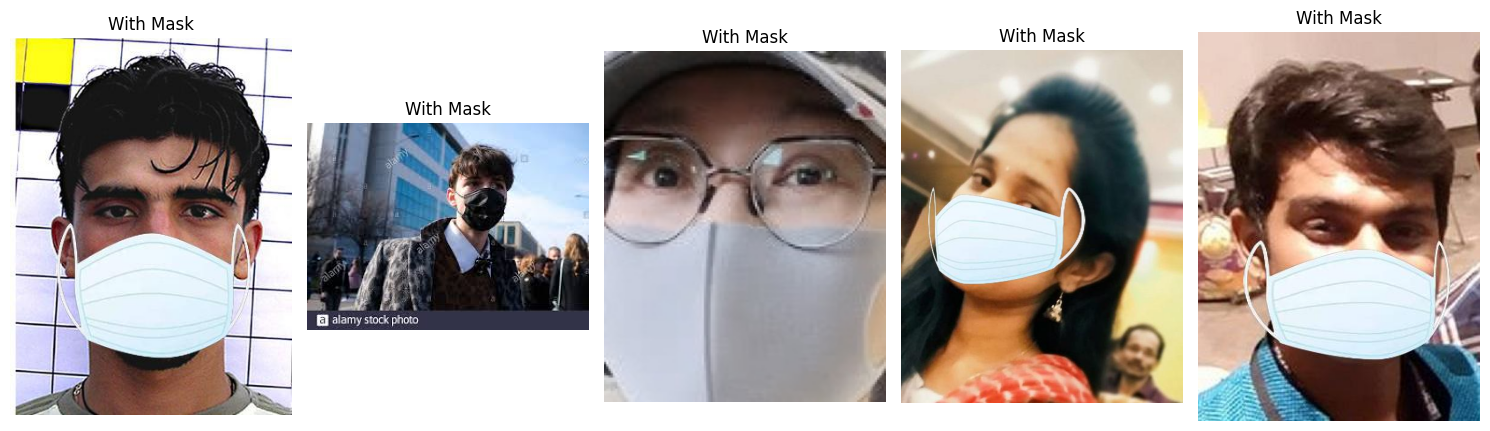

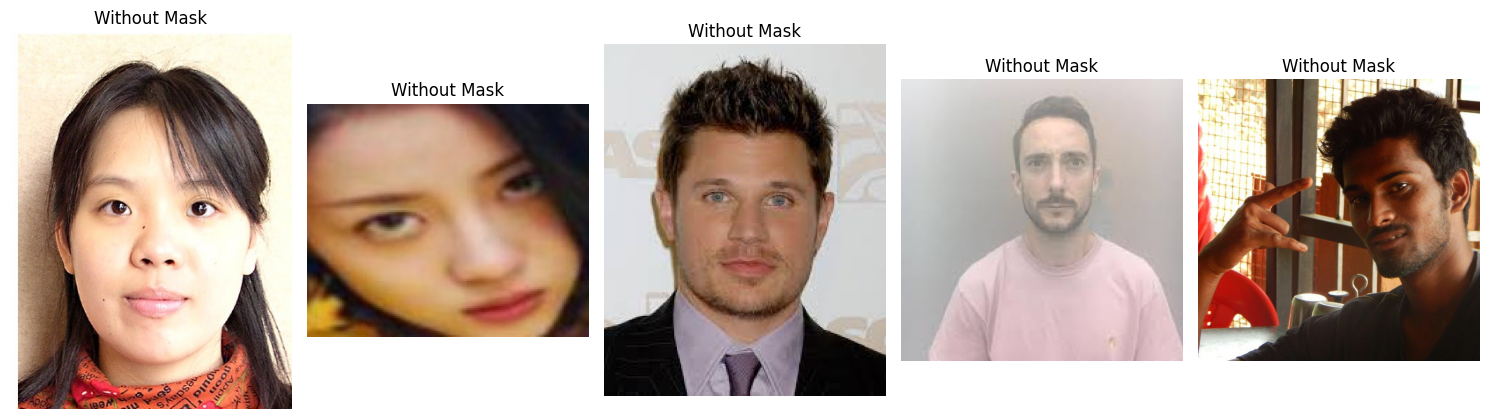

In [29]:
def show_sample_images(folder, title, n=5):
    images = os.listdir(folder)[:n]
    plt.figure(figsize=(15,5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{title}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize
show_sample_images(with_mask_dir, "With Mask")
show_sample_images(without_mask_dir, "Without Mask")


In [30]:
# Create combined directory structure for ImageDataGenerator
import shutil

base_dir = "/content/face_mask_dataset"
train_with_mask = os.path.join(base_dir, "with_mask")
train_without_mask = os.path.join(base_dir, "without_mask")

# Create folders
os.makedirs(train_with_mask, exist_ok=True)
os.makedirs(train_without_mask, exist_ok=True)

# Move images
for file in os.listdir(with_mask_dir):
    shutil.copy(os.path.join(with_mask_dir, file), train_with_mask)

for file in os.listdir(without_mask_dir):
    shutil.copy(os.path.join(without_mask_dir, file), train_without_mask)


In [31]:
IMG_SIZE = 128

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


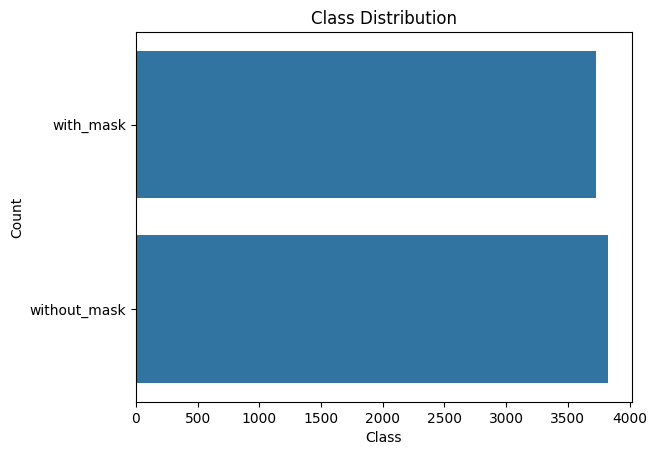

In [32]:
labels = ['with_mask'] * 3725 + ['without_mask'] * 3828
sns.countplot(labels)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


# CNN Model

In [33]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [34]:
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)


history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7558 - loss: 0.4667 - precision: 0.7674 - recall: 0.7659
Epoch 1: val_accuracy improved from -inf to 0.89007, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 43s 207ms/step - accuracy: 0.7562 - loss: 0.4661 - precision: 0.7678 - recall: 0.7662 - val_accuracy: 0.8901 - val_loss: 0.2761 - val_precision: 0.9601 - val_recall: 0.8170
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8978 - loss: 0.2514 - precision: 0.9135 - recall: 0.8793
Epoch 2: val_accuracy improved from 0.89007 to 0.90927, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 37s 195ms/step - accuracy: 0.8978 - loss: 0.2514 - precision: 0.9135 - recall: 0.8794 - val_accuracy: 0.9093 - val_loss: 0.2282 - val_precision: 0.9687 - val_recall: 0.8484
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9043 - loss: 0.2214 - precision: 0.9258 - recall: 0.8807
Epoch 3: val_accuracy improved from 0.90927 to 0.94371, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 193ms/step - accuracy: 0.9043 - loss: 0.2214 - precision: 0.9258 - recall: 0.8808 - val_accuracy: 0.9437 - val_loss: 0.1828 - val_precision: 0.9509 - val_recall: 0.9373
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9201 - loss: 0.2005 - precision: 0.9224 - recall: 0.9139
Epoch 4: val_accuracy did not improve from 0.94371
189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.9201 - loss: 0.2005 - precision: 0.9225 - recall: 0.9139 - val_accuracy: 0.9093 - val_loss: 0.2477 - val_precision: 0.9861 - val_recall: 0.8327
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9231 - loss: 0.1841 - precision: 0.9291 - recall: 0.9181
Epoch 5: val_accuracy did not improve from 0.94371
189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.9231 - loss: 0.1840 - precision: 0.9291 - recall: 0.9182 - val_accuracy: 0.9384 - val_loss: 0.1521 - val_precision: 0.9680 - val_recall: 0.9085
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s

189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - accuracy: 0.9389 - loss: 0.1528 - precision: 0.9363 - recall: 0.9433 - val_accuracy: 0.9550 - val_loss: 0.1332 - val_precision: 0.9665 - val_recall: 0.9438
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9568 - loss: 0.1177 - precision: 0.9531 - recall: 0.9623
Epoch 8: val_accuracy improved from 0.95497 to 0.96093, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.9568 - loss: 0.1177 - precision: 0.9531 - recall: 0.9623 - val_accuracy: 0.9609 - val_loss: 0.1306 - val_precision: 0.9620 - val_recall: 0.9608
Epoch 9/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9536 - loss: 0.1201 - precision: 0.9555 - recall: 0.9516
Epoch 9: val_accuracy did not improve from 0.96093
189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.9535 - loss: 0.1202 - precision: 0.9554 - recall: 0.9516 - val_accuracy: 0.9444 - val_loss: 0.1340 - val_precision: 0.9697 - val_recall: 0.9190
Epoch 10/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9628 - loss: 0.1058 - precision: 0.9648 - recall: 0.9630
Epoch 10: val_accuracy did not improve from 0.96093
189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.9628 - loss: 0.1058 - precision: 0.9648 - recall: 0.9630 - val_accuracy: 0.9483 - val_loss: 0.1425 - val_precision: 0.9550 - val_recall: 0.9425
Epoch 11/20
189/189 ━━━━━━━━━━━━━━━━━━━━

189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - accuracy: 0.9648 - loss: 0.0942 - precision: 0.9646 - recall: 0.9658 - val_accuracy: 0.9689 - val_loss: 0.1151 - val_precision: 0.9724 - val_recall: 0.9660
Epoch 13/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9750 - loss: 0.0680 - precision: 0.9744 - recall: 0.9759
Epoch 13: val_accuracy did not improve from 0.96887
189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.9750 - loss: 0.0680 - precision: 0.9744 - recall: 0.9758 - val_accuracy: 0.9669 - val_loss: 0.1150 - val_precision: 0.9773 - val_recall: 0.9569
Epoch 14/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9654 - loss: 0.0860 - precision: 0.9653 - recall: 0.9669
Epoch 14: val_accuracy did not improve from 0.96887
189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.9654 - loss: 0.0860 - precision: 0.9653 - recall: 0.9668 - val_accuracy: 0.9437 - val_loss: 0.1548 - val_precision: 0.9709 - val_recall: 0.9163
Epoch 15/20
189/189 ━━━━━━━━━━━━━━━━━━

# Accuracy and Loss plot


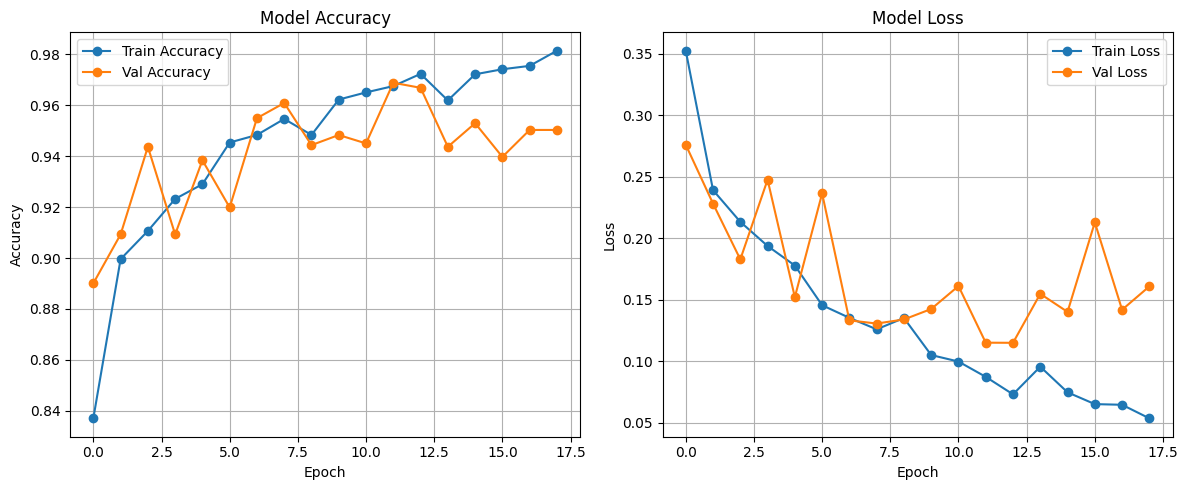

In [35]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate

In [54]:
# Create ImageDataGenerator for test/validation
# only rescaling
eval_datagen = ImageDataGenerator(rescale=1./255)

test_generator = eval_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 7553 images belonging to 2 classes.


237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step


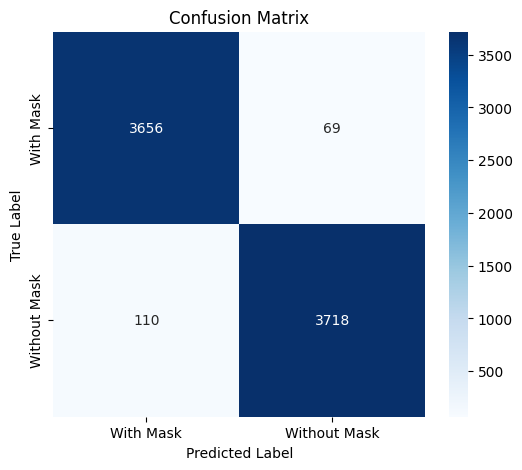

In [58]:
# Predict on test_generator
y_true = test_generator.classes
y_pred_probs = best_model.predict(test_generator, verbose=1)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int).flatten()      # Convert to 0 or 1

cm = confusion_matrix(y_true, y_pred)
labels = ['With Mask', 'Without Mask']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [59]:
# Report
acc = accuracy_score(y_true, y_pred)
print(f" Accuracy: {acc:.4f}")
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

 Accuracy: 0.9763

 Classification Report:
              precision    recall  f1-score   support

   With Mask       0.97      0.98      0.98      3725
Without Mask       0.98      0.97      0.98      3828

    accuracy                           0.98      7553
   macro avg       0.98      0.98      0.98      7553
weighted avg       0.98      0.98      0.98      7553



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


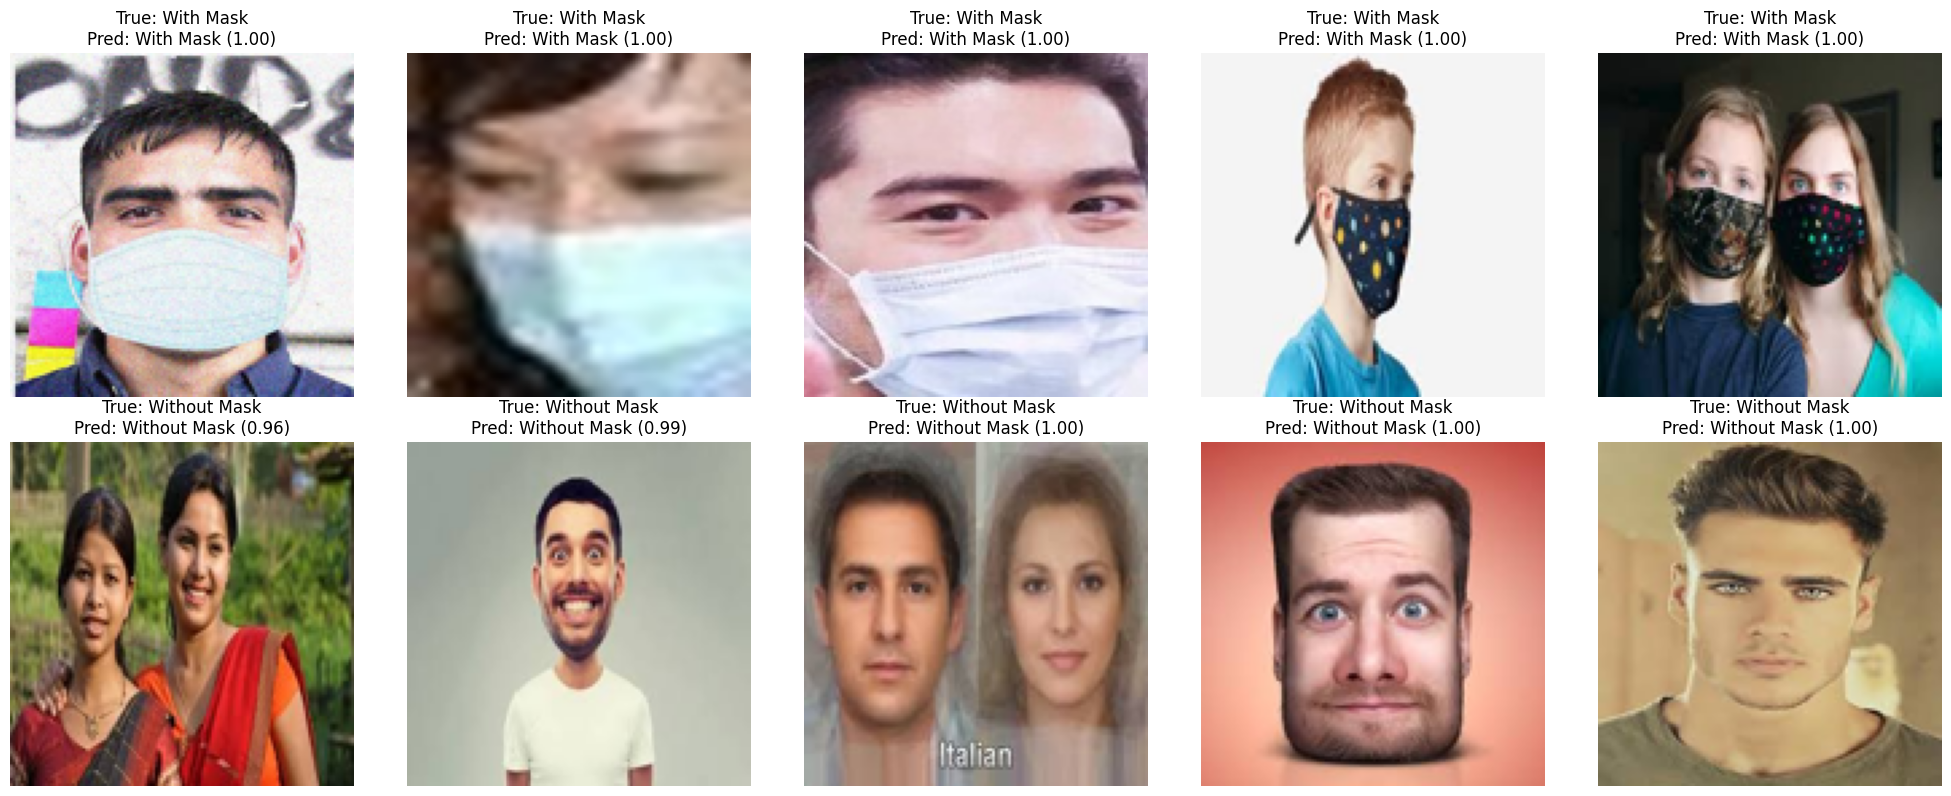

In [37]:
def predict_multiple_images(model, with_mask_dir, without_mask_dir, num_each=5):
    # Get sample image paths
    with_mask_samples = random.sample(os.listdir(with_mask_dir), num_each)
    without_mask_samples = random.sample(os.listdir(without_mask_dir), num_each)

    all_samples = [(os.path.join(with_mask_dir, img), "With Mask") for img in with_mask_samples] + \
                  [(os.path.join(without_mask_dir, img), "Without Mask") for img in without_mask_samples]

    # Plot
    plt.figure(figsize=(20, 8))
    for i, (img_path, true_label) in enumerate(all_samples):
        img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img) / 255.0
        img_array = img_array.reshape(1, IMG_SIZE, IMG_SIZE, 3)

        pred = model.predict(img_array)[0][0]
        pred_label = "Without Mask" if pred > 0.5 else "With Mask"
        confidence = pred if pred > 0.5 else 1 - pred

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
predict_multiple_images(best_model, with_mask_dir, without_mask_dir, num_each=5)
